# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples),                                                                                  # therefore you should add a comma after the values. 
                                                                                  # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 7, 3, padding=0, bias=0),     #Input-1x28x28     Output-7x26x26     RF-3
            nn.ReLU(),
            nn.BatchNorm2d(7),
            nn.Conv2d(7, 14, 3, padding=0, bias=0),    #Input-7x26x26     Output-14x24x24    RF-5
            nn.ReLU(),
            nn.BatchNorm2d(14),

            nn.Conv2d(14, 7, 1),                       #Input-14x24x24    Output-7x24x24     RF-10
            nn.MaxPool2d(2, 2)                         #Input-7x24x24     Output-7x12x12     RF-10
            
            
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(7, 14, 3, padding=0, bias=0),    #Input-7x12x12        Output-14x10x10    RF-12
            nn.ReLU(),
            nn.BatchNorm2d(14),
            nn.Conv2d(14, 28, 3, padding=1, bias=0),    #Input-14x10x10      Output-28x10x10    RF-14
            nn.ReLU(),
            nn.BatchNorm2d(28),

            nn.Conv2d(28, 14, 1),                       #Input-28x10x10      Output-14x10x10    RF-28
            nn.MaxPool2d(2, 2)                          #Input-14x5x5        Output-14x5x5      RF-28 
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(14, 21, 3, padding=1, bias=0),    #Input-14x5x5    Output-21x5x5    RF-30
            nn.ReLU(),
            nn.BatchNorm2d(21),

            nn.Conv2d(21, 40, 1)                        #Input-21x5x5    Output-40x5x5    RF-30 
        )
        
        self.avgpool = nn.AvgPool2d(5)                  #Input-40x5x5    Output-40x1x1

        self.out = nn.Sequential(
            nn.Conv2d(40, 10, 1, bias=0)                #Input-40x1x1      Output-10x1x1
        )        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.avgpool(x)
        x = self.out(x)
        x = x.squeeze()
        x = F.log_softmax(x, dim=1)
        return x

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

You should consider upgrading via the '/home/sahil/miniconda3/envs/deeplearning/bin/python -m pip install --upgrade pip' command.
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 7, 26, 26]              63
              ReLU-2            [-1, 7, 26, 26]               0
       BatchNorm2d-3            [-1, 7, 26, 26]              14
            Conv2d-4           [-1, 14, 24, 24]             882
              ReLU-5           [-1, 14, 24, 24]               0
       BatchNorm2d-6           [-1, 14, 24, 24]              28
            Conv2d-7            [-1, 7, 24, 24]             105
         MaxPool2d-8            [-1, 7, 12, 12]               0
            Conv2d-9           [-1, 14, 10, 10]             882
             ReLU-10           [-1, 14, 10, 10]               0
      BatchNorm2d-11           [-1, 14, 10, 10]              28
           Conv2d-12           [

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [8]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]EPOCH: 0
Loss=0.05864724889397621 Batch_id=468 Accuracy=82.17: 100%|██████████| 469/469 [00:03<00:00, 126.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.1300, Accuracy: 9664/10000 (96.64%)

EPOCH: 1
Loss=0.09804793447256088 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:03<00:00, 128.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0724, Accuracy: 9800/10000 (98.00%)

EPOCH: 2
Loss=0.032464150339365005 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:03<00:00, 128.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0498, Accuracy: 9844/10000 (98.44%)

EPOCH: 3
Loss=0.09433526545763016 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:03<00:00, 124.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]
Test set: Average loss: 0.0462, Accuracy: 9853/10000 (98.53%)

EPOCH: 4
Loss=0.011649586260318756 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00

# Let's Train and test our model

This time let's add a scheduler for out LR. 

Text(0.5, 1.0, 'Test Accuracy')

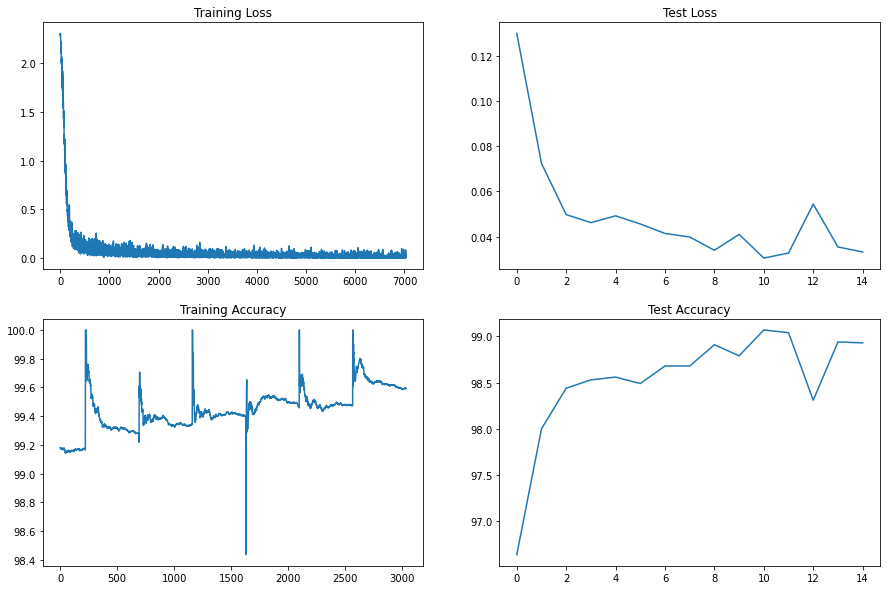

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")